In [474]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import pickle
from collections import defaultdict, Counter
import warnings
import Bio.PDB

## DMS single mutant effects on affinity

In [529]:
dms_df = pd.read_csv("https://media.githubusercontent.com/media/jbloomlab/Ab-CGGnaive_DMS/main/results/final_variant_scores/final_variant_scores.csv", index_col="mutation", dtype=dict(position_IMGT=pd.Int16Dtype()))
# remove linker sites
dms_df = dms_df[dms_df.chain != "link"]
# add indicator for wildtype data
dms_df["WT"] = dms_df.wildtype == dms_df.mutant
assert dms_df.position_IMGT.max() < 1000
dms_df["site"] = [f"{chain}-{str(pos).zfill(3)}" for chain, pos in zip(dms_df.chain, dms_df.position_IMGT)]
dms_df

,target,wildtype,position,position_IMGT,chain,mutant,codon,single_nt,bind,delta_bind,...,expr,delta_expr,n_bc_expr,n_libs_expr,psr,delta_psr,n_bc_psr,n_libs_psr,WT,site
mutation,,,,,,,,,,,,,,,,,,,,,
E1(H)A,CGG_naive,E,1,1,H,A,GAG,True,10.48829,0.03110,...,10.44614,-0.00453,19.0,2.0,6.78608,-0.07452,17.0,2.0,False,H-001
E1(H)C,CGG_naive,E,1,1,H,C,GAG,False,10.44477,-0.01243,...,10.32364,-0.12703,20.0,2.0,7.44234,0.58174,17.0,2.0,False,H-001
E1(H)D,CGG_naive,E,1,1,H,D,GAG,True,10.42771,-0.02948,...,10.51618,0.06551,16.0,2.0,6.95940,0.09880,13.0,2.0,False,H-001
E1(H)E,CGG_naive,E,1,1,H,E,GAG,True,10.45719,0.00000,...,10.45067,0.00000,21170.0,2.0,6.86060,0.00000,18910.0,2.0,True,H-001
E1(H)F,CGG_naive,E,1,1,H,F,GAG,False,10.51899,0.06180,...,10.33163,-0.11904,24.0,2.0,6.91372,0.05313,21.0,2.0,False,H-001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
R124(L)S,CGG_naive,R,235,124,L,S,CGT,True,10.44756,-0.00963,...,10.54313,0.09246,39.0,2.0,6.93925,0.07866,33.0,2.0,False,L-124
R124(L)T,CGG_naive,R,235,124,L,T,CGT,False,10.43023,-0.02696,...,10.53860,0.08793,36.0,2.0,6.88956,0.02896,34.0,2.0,False,L-124
R124(L)V,CGG_naive,R,235,124,L,V,CGT,False,10.38231,-0.07488,...,10.48707,0.03640,27.0,2.0,6.78160,-0.07899,24.0,2.0,False,L-124


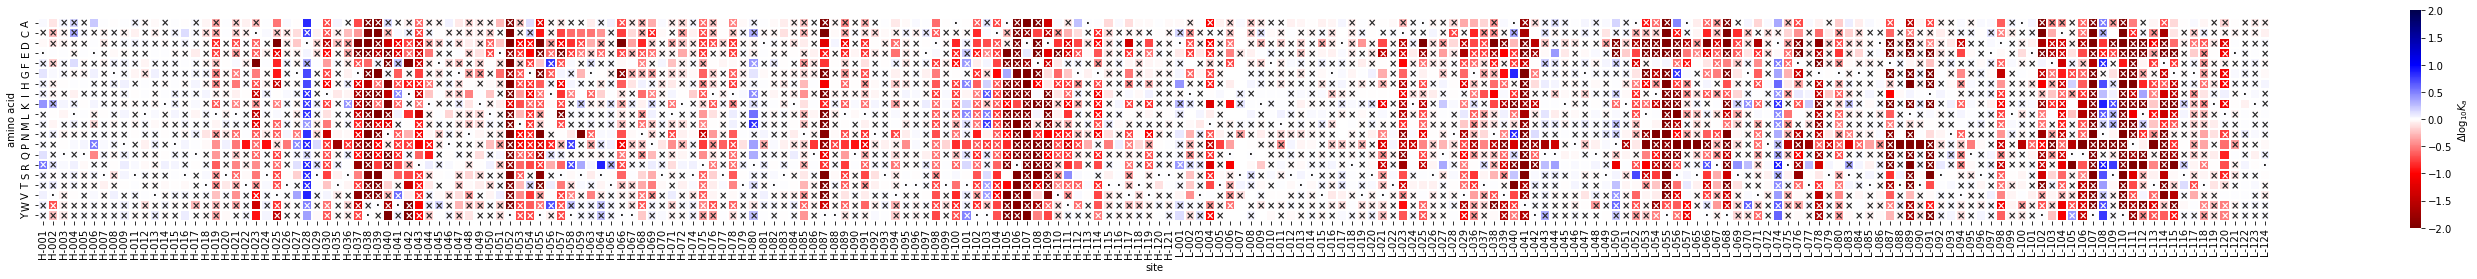

In [530]:
bind_df = dms_df.pivot(index="mutant", columns="site", values="delta_bind")

accessible_df = dms_df.pivot(index="mutant", columns="site", values="single_nt")
wt_df = dms_df.pivot(index="mutant", columns="site", values="WT")

annot = pd.DataFrame(np.empty_like(bind_df, dtype=str), index=bind_df.index, columns=bind_df.columns)
annot.iloc[wt_df.values.astype(bool)] = "\u00B7"
annot.iloc[~accessible_df.values.astype(bool)] = "\u00D7"

vmax = 2
vmin = -2

plt.figure(figsize=(50, 4))
sns.heatmap(bind_df, center=0, vmin=vmin, vmax=vmax, annot=annot, fmt="", annot_kws=dict(fontweight="bold"),
            cmap="seismic_r", cbar_kws=dict(label=r"$\Delta\log_{10} K_a$"), linewidths=.1, square=True)
plt.xlabel("site")
plt.ylabel("amino acid")
plt.show()

In [616]:
expr_df = dms_df.pivot(index="mutant", columns="site", values="delta_expr")

## Mutations in GC trees

In [531]:
results = glob.glob("../nextflow/results/*")[-1]
results

'../nextflow/results/2022-04-01'

In [532]:
def gc_key(file):
    PR_str = file.split("/")[-2].split("-")
    return int(PR_str[1]), int(PR_str[3])

files = sorted(glob.glob(f"{results}/gctrees/PR*/gctree.p"), key=gc_key)

trees = {}
for file in files:
    key = "_".join(f"{x}{y}" for x, y in zip(("mouse", "GC"), gc_key(file)))
    assert key not in trees, key
    trees[key] = pickle.load(open(file, "rb"))

    
#     trees = {"_".join(f"{x}{y}" for x, y in zip(("mouse", "GC"), gc_key(file))): pickle.load(open(file, "rb"))
#          for file in files}

print(f"loaded {len(trees)} GC trees")

loaded 77 GC trees


In [533]:
pos_df = pd.read_csv("https://raw.githubusercontent.com/jbloomlab/Ab-CGGnaive_DMS/main/data/CGGnaive_sites.csv", dtype=dict(site=pd.Int16Dtype()), index_col="site_scFv")
pos_df

,amino_acid,chain,site,KI_codon
site_scFv,,,,
1,E,H,1,GAG
2,V,H,2,GTG
3,Q,H,3,CAG
4,L,H,4,CTT
5,Q,H,5,CAG
...,...,...,...,...
231,L,L,120,CTA
232,E,L,121,GAA
233,I,L,122,ATA


In [534]:
igh_pos_map = pos_df.loc[pos_df.chain == "H", "site"].reset_index(drop=True)
igk_pos_map = pos_df.loc[pos_df.chain == "L", "site"].reset_index(drop=True)

## Codon-wise first step mutations

In [626]:
hits_df = pd.DataFrame(np.zeros_like(bind_df.values), index=bind_df.index, columns=bind_df.columns)

# hits_df.values[wt_df.values] = np.nan
# hits_df.values[~accessible_df.values.astype(bool)] = np.nan

dms_df["gctree incidence"] = 0

for gc, tree in trees.items():
    already_hit = defaultdict(set)
    for node in tree.tree.traverse(strategy="preorder"):
        if not node.is_root():
            already_hit[node] = already_hit[node.up].copy()
            already_hit[node].update((mutation[:-1] for mutation in node.mutations))
        for mutation in node.mutations:
            if mutation[:-1] not in already_hit[node.up]:
                mutant = mutation[-1]
                if mutant != "*":
                    site = dms_df.site[mutation]
                    hits_df.loc[mutant, site] += 1
                    dms_df.loc[mutation, "gctree incidence"] += 1

hits_df

site,H-001,H-002,H-003,H-004,H-005,H-006,H-007,H-008,H-009,H-011,...,L-115,L-116,L-117,L-118,L-119,L-120,L-121,L-122,L-123,L-124
mutant,,,,,,,,,,,,,,,,,,,,,
A,3.0,2.0,0.0,0.0,0.0,6.0,1.0,0.0,0.0,0.0,...,5.0,7.0,0.0,2.0,0.0,0.0,2.0,1.0,0.0,0.0
C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
D,13.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,4.0,0.0,0.0,0.0,2.0,0.0,25.0,0.0,0.0,0.0
E,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,3.0,0.0,23.0,0.0,0.0,0.0,26.0,0.0
F,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
G,5.0,1.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,11.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
H,0.0,0.0,6.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
I,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,3.0,1.0,1.0,0.0,0.0,12.0,0.0
K,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,9.0,13.0,0.0,0.0


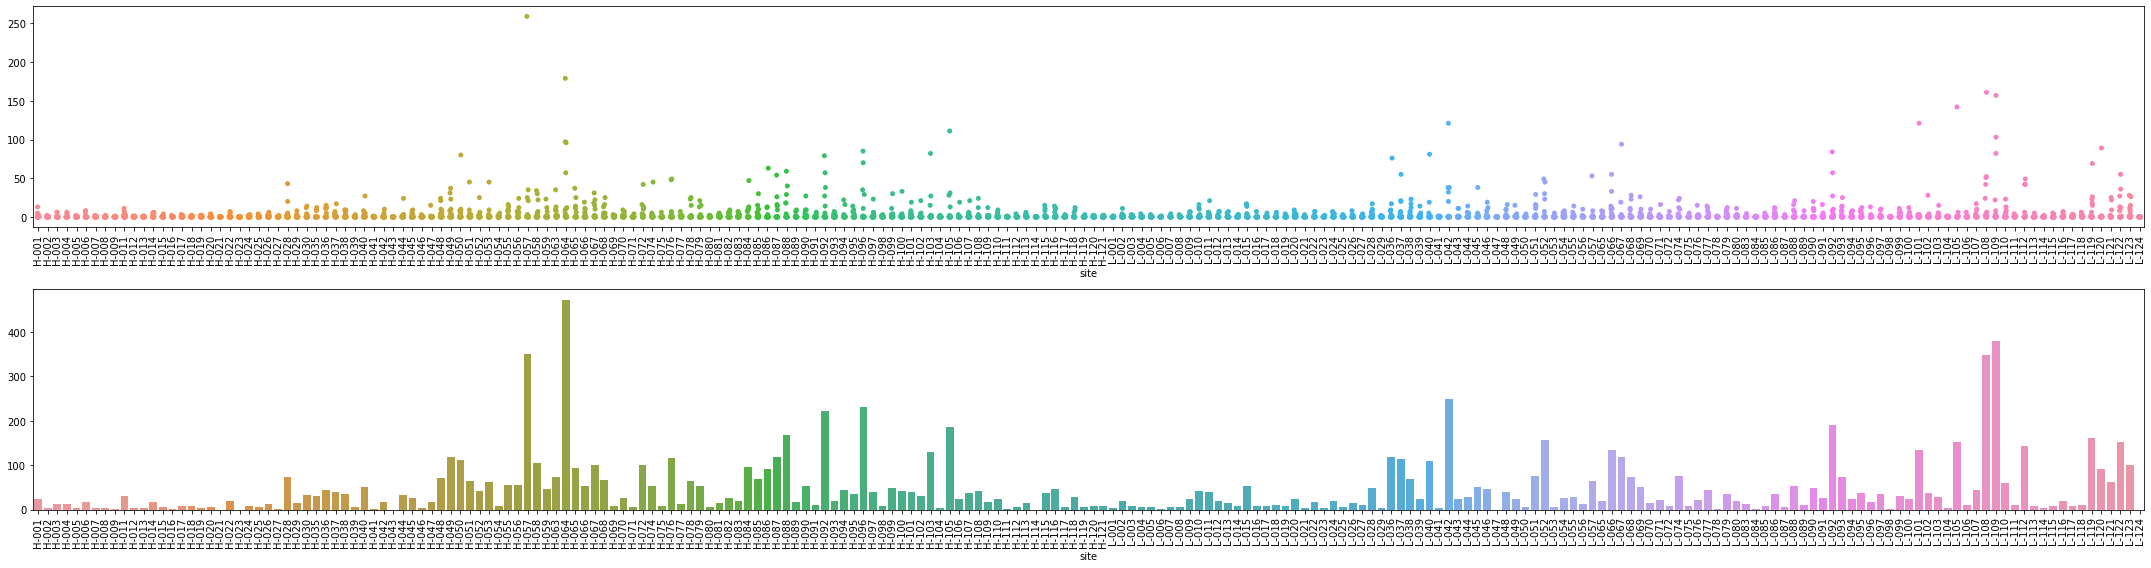

In [536]:
plt.figure(figsize=(30, 8))

plt.subplot(211)
g = sns.stripplot(data=hits_df)
for item in g.get_xticklabels():
    item.set_rotation(90)

plt.subplot(212, sharex=g)
g = sns.barplot(data=hits_df, ci=None, estimator=sum)
for item in g.get_xticklabels():
    item.set_rotation(90)

plt.tight_layout()
plt.show()

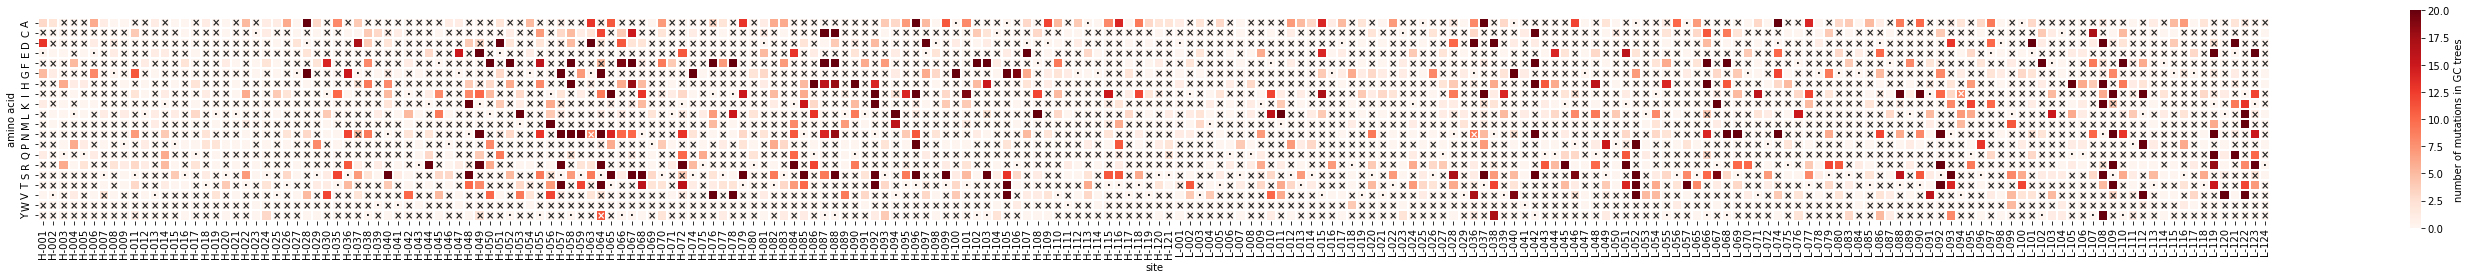

In [537]:
plt.figure(figsize=(50, 4))
sns.heatmap(hits_df, vmin=0, annot=annot, fmt="", annot_kws=dict(fontweight="bold"),
            cmap="Reds",
            vmax=20,
            cbar_kws=dict(label="number of mutations in GC trees"), linewidths=.1, square=True)
plt.xlabel("site")
plt.ylabel("amino acid")
plt.show()

## Add mutability to `dms_df`

In [627]:
from Bio.codonalign.codonseq import CodonSeq

mutability = pd.read_csv("../nextflow/data/mutability/MK_RS5NF_mutability.csv", sep=" ", index_col=0).squeeze("columns")
substitution = pd.read_csv("../nextflow/data/mutability/MK_RS5NF_substitution.csv", sep=" ", index_col=0)

naive = next(iter(trees.values())).tree.sequence

padded_igh = "NN" + naive[:igk_idx] + "NN"
padded_igk = "NN" + naive[igk_idx:] + "NN"
# mutabilities of each nucleotide
contexts = [padded_igh[(i - 2) : (i + 3)]
                for i in range(2, len(padded_igh) - 2)
               ] + [padded_igk[(i - 2) : (i + 3)]
                    for i in range(2, len(padded_igk) - 2)
                   ]

# mutation rates at each site in naive
mutation_rates_nt = pd.concat((mutability[context] * substitution.loc[context] for context in contexts), axis=1).T.reset_index()

# now we want the above at the codon level
codons = CodonSeq(naive)

assert len(contexts) == len(naive) == len(codons)

dms_df["S5F mutation rate"] = 0

for codon_idx in range(codons.get_codon_num()):
    codon = CodonSeq(codons.get_codon(codon_idx))
    aa = codon.translate()
    for codon_pos in range(3):
        idx = 3 * codon_idx + codon_pos
        if idx < igk_idx:
            chain = "H"
            imgt_idx = igh_pos_map[idx // 3]
        else:
            chain = "L"
            imgt_idx = igk_pos_map[(idx - igk_idx) // 3]
        assert naive[idx] == codon[codon_pos]
        for alt_nt in "ACGT":
            if alt_nt != naive[idx]:
                mutated_codon = list(codon)
                mutated_codon[codon_pos] = alt_nt
                mutated_codon = CodonSeq("".join(mutated_codon))
                mutated_aa = mutated_codon.translate()
                if mutated_aa != "*" and mutated_aa != aa:
                    mutation = f"{aa}{imgt_idx}({chain}){mutated_aa}"
                    dms_df.loc[mutation, "S5F mutation rate"] += mutation_rates_nt.loc[idx, alt_nt]
dms_df

,target,wildtype,position,position_IMGT,chain,mutant,codon,single_nt,bind,delta_bind,...,delta_psr,n_bc_psr,n_libs_psr,WT,site,gctree_incidence,S5F_mutation_rate,distance to antigen,gctree incidence,S5F mutation rate
mutation,,,,,,,,,,,,,,,,,,,,,
E1(H)A,CGG_naive,E,1,1,H,A,GAG,True,10.48829,0.03110,...,-0.07452,17.0,2.0,False,H-001,3,0.000123,9.796122,3,0.000123
E1(H)C,CGG_naive,E,1,1,H,C,GAG,False,10.44477,-0.01243,...,0.58174,17.0,2.0,False,H-001,0,0.000000,9.796122,0,0.000000
E1(H)D,CGG_naive,E,1,1,H,D,GAG,True,10.42771,-0.02948,...,0.09880,13.0,2.0,False,H-001,13,0.000103,9.796122,13,0.000103
E1(H)E,CGG_naive,E,1,1,H,E,GAG,True,10.45719,0.00000,...,0.00000,18910.0,2.0,True,H-001,0,0.000000,9.796122,0,0.000000
E1(H)F,CGG_naive,E,1,1,H,F,GAG,False,10.51899,0.06180,...,0.05313,21.0,2.0,False,H-001,0,0.000000,9.796122,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
R124(L)S,CGG_naive,R,235,124,L,S,CGT,True,10.44756,-0.00963,...,0.07866,33.0,2.0,False,L-124,0,0.000000,NaN,0,0.000000
R124(L)T,CGG_naive,R,235,124,L,T,CGT,False,10.43023,-0.02696,...,0.02896,34.0,2.0,False,L-124,0,0.000000,NaN,0,0.000000
R124(L)V,CGG_naive,R,235,124,L,V,CGT,False,10.38231,-0.07488,...,-0.07899,24.0,2.0,False,L-124,0,0.000000,NaN,0,0.000000


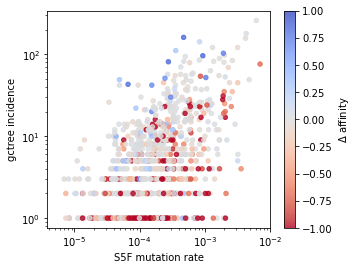

In [710]:
plt.figure(figsize=(5, 4))
plt.scatter(dms_df["S5F mutation rate"], dms_df["gctree incidence"], c=dms_df.delta_bind, s=20, alpha=0.8,
            cmap="coolwarm_r", vmin=-1, vmax=1)
plt.xlabel("S5F mutation rate")
plt.ylabel("gctree incidence")
plt.xscale("log")
plt.yscale("log")
plt.colorbar(label=r"$\Delta$ affinity")
plt.show()

## Binding Vs Expression Vs structure

In [539]:
# copypasta from polyclonal
def extract_atom_locations(
    input_pdbfile,
    target_chains,
    target_atom="CA",
):
    # read PDB, catch warnings about discontinuous chains
    with warnings.catch_warnings():
        warnings.simplefilter(
            "ignore", category=Bio.PDB.PDBExceptions.PDBConstructionWarning
        )
        pdb = Bio.PDB.PDBParser().get_structure("_", input_pdbfile)

    # get the chains out of the PDB
    chains = list(pdb.get_chains())
    chain_ids = [chain.id for chain in chains]

    # make sure the target chains are in the PDB
    for chain in target_chains:
        if chain not in chain_ids:
            raise ValueError(f"{chain} not in {input_pdbfile}")

    # make a list of chains to extract atom locations from
    chains_to_use = []
    for i, chain in enumerate(chain_ids):
        if chain in target_chains:
            chains_to_use.append(chains[i])

    # extract atom locations from target chains
    chain_list = []
    residue_list = []
    x_list = []
    y_list = []
    z_list = []
    for chain in chains_to_use:
        for residue in chain.get_residues():
            residue_number = residue.get_id()[1]
            atoms = residue.get_atoms()
            for atom in atoms:
                if atom.get_id() == target_atom:
                    x, y, z = atom.get_coord()
                    x_list.append(x)
                    y_list.append(y)
                    z_list.append(z)
                    residue_list.append(residue_number)
                    chain_list.append(chain.id)

    # write output
    output = pd.DataFrame(
        {
            "chain": chain_list,
            "site": residue_list,
            "x": x_list,
            "y": y_list,
            "z": z_list,
        }
    )

    return output.reset_index(drop=True)

In [723]:
def residue_depth(
    input_pdbfile,
    target_chain,
):
    parser = Bio.PDB.PDBParser()
    # read PDB, catch warnings about discontinuous chains
    with warnings.catch_warnings():
        warnings.simplefilter(
            "ignore", category=Bio.PDB.PDBExceptions.PDBConstructionWarning
        )
        pdb = Bio.PDB.PDBParser().get_structure("_", input_pdbfile)
    model = pdb[0]
    print(list(pdb.get_chains()))
    rd = Bio.PDB.ResidueDepth(model)
#     print(rd)
    
residue_depth("combined_ch2_eh2-coot_IMGT.pdb", "H")

[<Chain id=A>, <Chain id=H>, <Chain id=L>, <Chain id=B>, <Chain id=C>, <Chain id=D>]


/bin/sh: /Users/wdewitt/miniconda3/envs/rosetta/bin/msms: Bad CPU type in executable


RuntimeError: Failed to generate surface file using command:
msms -probe_radius 1.5 -if /var/folders/6f/7dchjc7x66sgw2k7m8rwlyzw0000gp/T/tmpdls_4xys -of /var/folders/6f/7dchjc7x66sgw2k7m8rwlyzw0000gp/T/tmpn9h0016d > /var/folders/6f/7dchjc7x66sgw2k7m8rwlyzw0000gp/T/tmpglw_s5ah

In [483]:
!curl https://raw.githubusercontent.com/jbloomlab/Ab-CGGnaive_DMS/dms-view/dms-view/combined_ch2_eh2-coot_IMGT.pdb -o combined_ch2_eh2-coot_IMGT.pdb

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  376k  100  376k    0     0  1191k      0 --:--:-- --:--:-- --:--:-- 1194k


In [540]:
coords_H = extract_atom_locations(open("combined_ch2_eh2-coot_IMGT.pdb"), "H").set_index("site").drop("chain", axis=1)
coords_L = extract_atom_locations(open("combined_ch2_eh2-coot_IMGT.pdb"), "L").set_index("site").drop("chain", axis=1)
coords_A = extract_atom_locations(open("combined_ch2_eh2-coot_IMGT.pdb"), "A").set_index("site").drop("chain", axis=1)
coords_B = extract_atom_locations(open("combined_ch2_eh2-coot_IMGT.pdb"), "B").set_index("site").drop("chain", axis=1)
coords_C = extract_atom_locations(open("combined_ch2_eh2-coot_IMGT.pdb"), "C").set_index("site").drop("chain", axis=1)
coords_D = extract_atom_locations(open("combined_ch2_eh2-coot_IMGT.pdb"), "D").set_index("site").drop("chain", axis=1)

Add distance info to dms_df

In [544]:
coords_L

,x,y,z
site,,,
1,137.317993,157.432999,169.117004
2,135.832993,154.018005,169.938995
3,134.294006,151.919998,172.697006
4,135.925995,148.505005,172.539001
5,134.113007,146.154007,174.936996
...,...,...,...
119,139.772995,135.639999,181.841003
120,140.578003,131.979996,180.955002
121,139.048996,129.811996,183.735001


In [546]:
for coords_Ab, chain in zip((coords_H, coords_L), "HL"):
    for i in coords_Ab.index:
        min_dist = np.inf
        for coords_Ag in (coords_A, coords_B, coords_C, coords_D):
            chain_min = np.linalg.norm(coords_Ab.loc[i] - coords_Ag, axis=1).min()
            if chain_min < min_dist:
                min_dist = chain_min
        dms_df.loc[(dms_df.chain == chain) & (dms_df.position_IMGT == i), "distance to antigen"] = min_dist

dms_df

,target,wildtype,position,position_IMGT,chain,mutant,codon,single_nt,bind,delta_bind,...,n_libs_expr,psr,delta_psr,n_bc_psr,n_libs_psr,WT,site,gctree_incidence,S5F_mutation_rate,distance to antigen
mutation,,,,,,,,,,,,,,,,,,,,,
E1(H)A,CGG_naive,E,1,1,H,A,GAG,True,10.48829,0.03110,...,2.0,6.78608,-0.07452,17.0,2.0,False,H-001,3,0.000123,9.796122
E1(H)C,CGG_naive,E,1,1,H,C,GAG,False,10.44477,-0.01243,...,2.0,7.44234,0.58174,17.0,2.0,False,H-001,0,0.000000,9.796122
E1(H)D,CGG_naive,E,1,1,H,D,GAG,True,10.42771,-0.02948,...,2.0,6.95940,0.09880,13.0,2.0,False,H-001,13,0.000103,9.796122
E1(H)E,CGG_naive,E,1,1,H,E,GAG,True,10.45719,0.00000,...,2.0,6.86060,0.00000,18910.0,2.0,True,H-001,0,0.000000,9.796122
E1(H)F,CGG_naive,E,1,1,H,F,GAG,False,10.51899,0.06180,...,2.0,6.91372,0.05313,21.0,2.0,False,H-001,0,0.000000,9.796122
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
R124(L)S,CGG_naive,R,235,124,L,S,CGT,True,10.44756,-0.00963,...,2.0,6.93925,0.07866,33.0,2.0,False,L-124,0,0.000000,NaN
R124(L)T,CGG_naive,R,235,124,L,T,CGT,False,10.43023,-0.02696,...,2.0,6.88956,0.02896,34.0,2.0,False,L-124,0,0.000000,NaN
R124(L)V,CGG_naive,R,235,124,L,V,CGT,False,10.38231,-0.07488,...,2.0,6.78160,-0.07899,24.0,2.0,False,L-124,0,0.000000,NaN


In [547]:
dms_df.to_csv("output/mutations.dms_with_gctree_incidence.csv")

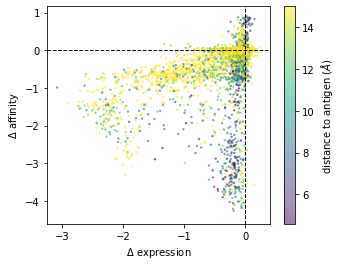

In [623]:
plt.figure(figsize=(5, 4))
plt.scatter(dms_df.delta_expr, y=dms_df.delta_bind, c=dms_df["distance to antigen"],
            s=2, alpha=0.5,
#             cmap="viridis",
#             vmin=0,
            vmax=15
           )
plt.axvline(0, ls="--", c="k", lw=1)
plt.axhline(0, ls="--", c="k", lw=1)
plt.xlabel(r"$\Delta$ expression")
plt.ylabel(r"$\Delta$ affinity")
plt.colorbar(label=r"distance to antigen ($\AA$)")
plt.savefig("output/plots/mutations.bind-expr-dist.pdf")
plt.show()

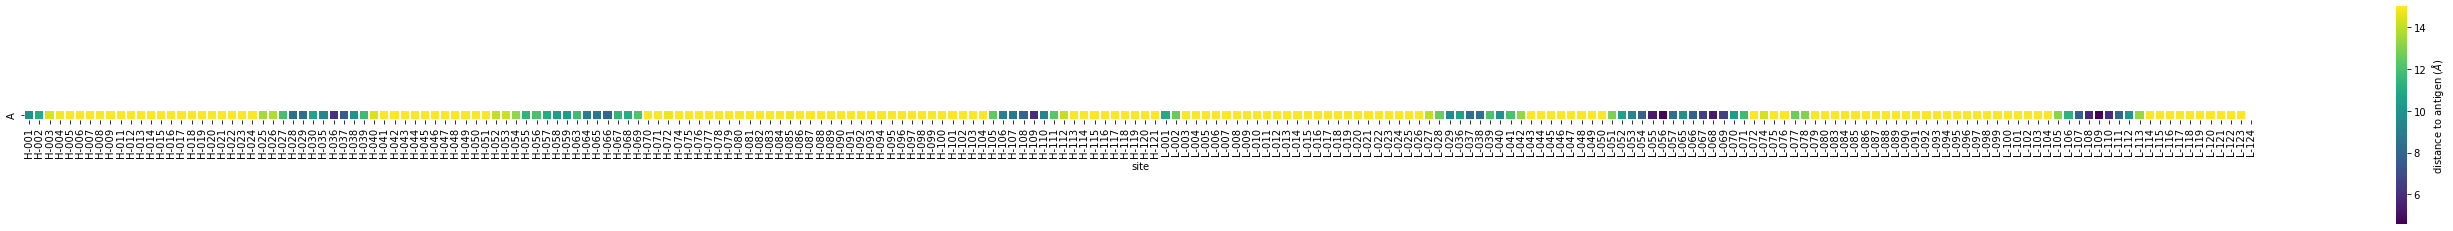

In [624]:
# note: seaborn can combine this annotation into the below heatmap. Look up how when not on a plane
#       should make another stripe of distance from solvent and align with expression heatmap

plt.figure(figsize=(50, 4))
sns.heatmap(pd.DataFrame(dms_df.pivot(index="mutant", columns="site", values="distance to antigen").iloc[0, :]).T,
            vmax=15, cmap="viridis",
            cbar_kws=dict(label=r"distance to antigen ($\AA$)"), linewidths=.1, square=True)
plt.savefig("output/plots/mutations.bind-heatmap-distances-row.pdf")
plt.show()

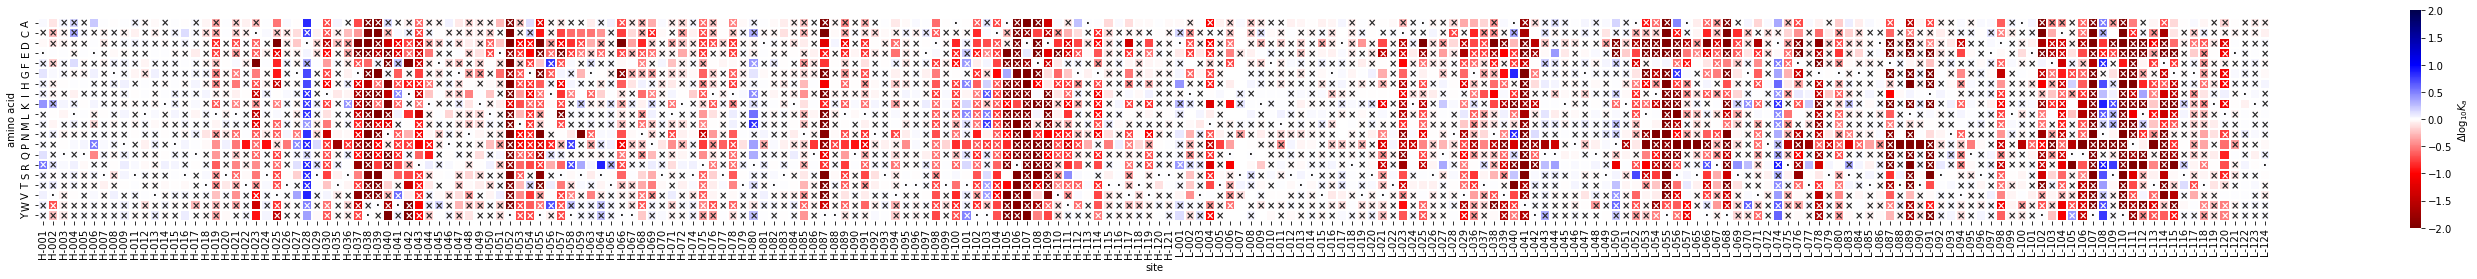

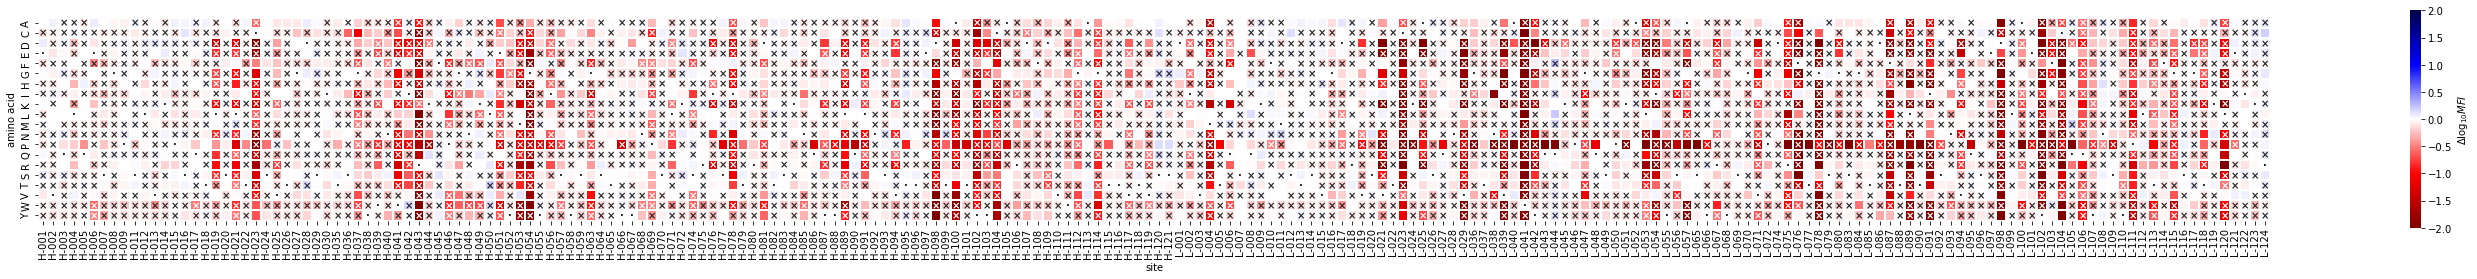

In [743]:
plt.figure(figsize=(50, 4))
sns.heatmap(bind_df, center=0, vmin=vmin, vmax=vmax, cmap="seismic_r", cbar_kws=dict(label=r"$\Delta\log_{10} K_a$"),
            annot=annot, fmt="", annot_kws=dict(fontweight="bold"),linewidths=.1, square=True)
plt.xlabel("site")
plt.ylabel("amino acid")
plt.savefig("output/plots/mutations.bind-heatmap.pdf")
plt.show()

plt.figure(figsize=(50, 4))
sns.heatmap(expr_df, center=0, vmin=vmin, vmax=vmax, annot=annot, fmt="", annot_kws=dict(fontweight="bold"),
            cmap="seismic_r", cbar_kws=dict(label=r"$\Delta\log_{10} MFI$"), linewidths=.1, square=True)
plt.xlabel("site")
plt.ylabel("amino acid")
plt.savefig("output/plots/mutations.expr-heatmap.pdf")
plt.show()

## High-incidence mutations

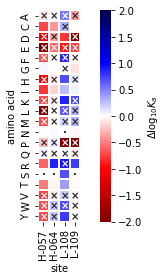

In [208]:
high_incidence = ["H-057", "H-064", "L-108", "L-109"]

plt.figure()
sns.heatmap(bind_df[high_incidence], center=0, vmin=vmin, vmax=vmax, annot=annot[high_incidence], fmt="", annot_kws=dict(fontweight="bold"),
            cmap="seismic_r", cbar_kws=dict(label=r"$\Delta\log_{10} K_a$"), linewidths=.1, square=True)
plt.xlabel("site")
plt.ylabel("amino acid")
plt.tight_layout()
plt.savefig("output/plots/mutations.high-incidence.pdf")
plt.show()

In [323]:
# sites =  dms_df.index.str[:-1].unique()
sites = ["S57(H)", "S64(H)", "N108(L)", "S109(L)"]

n_backgrounds = 0
background_counts = pd.Series(0, index=sites)

epi_df1 = pd.DataFrame(np.zeros((len(sites), len(sites))), index=sites, columns=sites)
epi_df2 = epi_df1.copy()

for gc, tree in trees.items():
    print(gc, end="       \r")
    for node in tree.tree.traverse(strategy="preorder"):
        if not node.is_root():
            parent_mutations = set(mutation[:-1] for mutation in node.up.mutations)
            n_backgrounds += 1
            for mutation in parent_mutations:
                if mutation in background_counts:
                    background_counts[mutation] += 1
            new_mutations = set(mutation[:-1] for mutation in node.mutations) - parent_mutations
            for mut1 in sites:
                for mut2 in sites:
                    if mut2 in new_mutations:
                        if mut1 in parent_mutations:
                            epi_df1.loc[mut1, mut2] += 1
                        else:
                            epi_df2.loc[mut1, mut2] += 1

frequent_enough = (epi_df1 + epi_df2).values.sum(1) > 50
                            
epi_df1 = epi_df1.divide(background_counts, axis=0)
epi_df2 = epi_df2.divide(n_backgrounds - background_counts, axis=0)

# odds ratio
epi_df = (epi_df1 / epi_df2).loc[frequent_enough, frequent_enough]

np.fill_diagonal(epi_df.values, np.nan)
epi_df

,S57(H),S64(H),N108(L),S109(L)
S57(H),NaN,1.079586,0.831076,1.053541
S64(H),0.773227,NaN,0.640172,0.829091
N108(L),0.970749,0.940724,NaN,0.999370
S109(L),0.957198,0.949150,0.504847,NaN


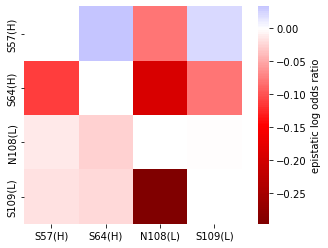

In [337]:
# plt.figure(figsize=(10, 10))
sns.heatmap(np.log10(epi_df), cmap="seismic_r", center=0, square=True, cbar_kws={'label': 'epistatic log odds ratio'})
plt.show()

<AxesSubplot:ylabel='Count'>

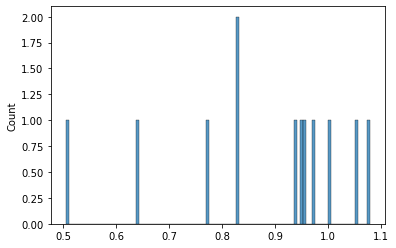

In [333]:
sns.histplot(x=np.ravel(epi_df.values), bins=100)

In [315]:
epi_df1

mutation,E1(H),V2(H),Q3(H),L4(H),Q5(H),E6(H),S7(H),G8(H),P9(H),S11(H),...,G115(L),S116(L),G117(L),T118(L),K119(L),L120(L),E121(L),I122(L),K123(L),R124(L)
mutation,,,,,,,,,,,,,,,,,,,,,
E1(H),0.000000,0.000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.015385,0.000000,0.0,0.015385,0.000000,0.015385,0.030769,0.000000,0.0
V2(H),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Q3(H),0.000000,0.000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
L4(H),0.000000,0.000,0.000000,0.000000,0.0,0.018182,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.036364,0.000000,0.036364,0.018182,0.036364,0.0
Q5(H),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
L120(L),0.000000,0.008,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.040000,0.000000,0.000000,0.024000,0.008000,0.0
E121(L),0.000000,0.000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.034483,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
I122(L),0.002841,0.000,0.002841,0.005682,0.0,0.005682,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.011364,0.011364,0.025568,0.000000,0.019886,0.0


In [316]:
background_counts

mutation
E1(H)       65
V2(H)        0
Q3(H)        5
L4(H)       55
Q5(H)        0
          ... 
L120(L)    125
E121(L)     29
I122(L)    352
K123(L)    120
R124(L)      0
Length: 220, dtype: int64

In [324]:
background_counts

S57(H)      839
S64(H)     1047
N108(L)    1951
S109(L)     856
dtype: int64

In [457]:
from scipy.stats import chi2_contingency

sites =  dms_df.index.str[:-1].unique()
# sites = ["S57(H)", "S64(H)", "N108(L)", "S109(L)"]

branch_mutations = []
branch_backgrounds = []
mutation_counts = Counter()
for gc, tree in trees.items():
    if gc.startswith("mouse7") or gc.startswith("mouse8"):
        print(f"skipping 10-week mouse {gc}")
        continue
    for node in tree.tree.traverse(strategy="preorder"):
        if not node.is_root():
            parent_mutations = set(mutation[:-1] for mutation in node.up.mutations)
            new_mutations = set(mutation[:-1] for mutation in node.mutations)
            branch_mutations.append((new_mutations - parent_mutations) & set(sites))
            branch_backgrounds.append(parent_mutations)
            mutation_counts.update(new_mutations)

chi2_df = pd.DataFrame(np.nan, index=sites, columns=sites)
p_value_df = pd.DataFrame(np.nan, index=sites, columns=sites)
for i in range(len(sites)):
    for j in range(i + 1, len(sites)):
        site1 = sites[i]
        site2 = sites[j]
        if mutation_counts[site1] < 20 or mutation_counts[site2] < 20:
            continue
        contingency_table = np.zeros((2, 2), dtype=int)
        for new_mutations, new_background in zip(branch_mutations, branch_backgrounds):
            contingency_table[int(site1 in new_background), int(site2 in new_mutations)] += 1

        if any(contingency_table.sum(0) == 0) or any(contingency_table.sum(1) == 0):
            continue
            
        chi2, p_value = chi2_contingency(contingency_table)[:2]
        
        chi2_df.loc[site1, site2] = chi2
        p_value_df.loc[site1, site2] = p_value
  
        if p_value < 1e-4:
            print(f"{site1},{site2}")
            print(contingency_table)
            print(p_value, flush=True)
            
    print(f"{(i + 1) / len(sites):.1%}", end="    \r")
                       

skipping 10-week mouse mouse7_GC90
skipping 10-week mouse mouse7_GC91
skipping 10-week mouse mouse7_GC92
skipping 10-week mouse mouse7_GC93
skipping 10-week mouse mouse8_GC84
skipping 10-week mouse mouse8_GC85
skipping 10-week mouse mouse8_GC86
skipping 10-week mouse mouse8_GC87
skipping 10-week mouse mouse8_GC88
skipping 10-week mouse mouse8_GC89
F45(H),Y52(H)       
[[5486   37]
 [   1    1]]
3.1694387932989644e-05
F45(H),F108(H)
[[5488   35]
 [   1    1]]
1.8643878139818745e-05
L50(H),M53(H)
[[5373   43]
 [ 103    6]]
2.9013363862849573e-06
I56(H),Q106(L)
[[5508    8]
 [   8    1]]
5.946531028089476e-05
T82(H),Y66(L)
[[5402  116]
 [   4    3]]
9.339914753770273e-10
A100(L),Q106(L)                                          
[[5511    8]
 [   5    1]]
6.855341127081216e-07
N108(L),L112(L)
[[3843  111]
 [1558   13]]
1.1812158730493316e-05


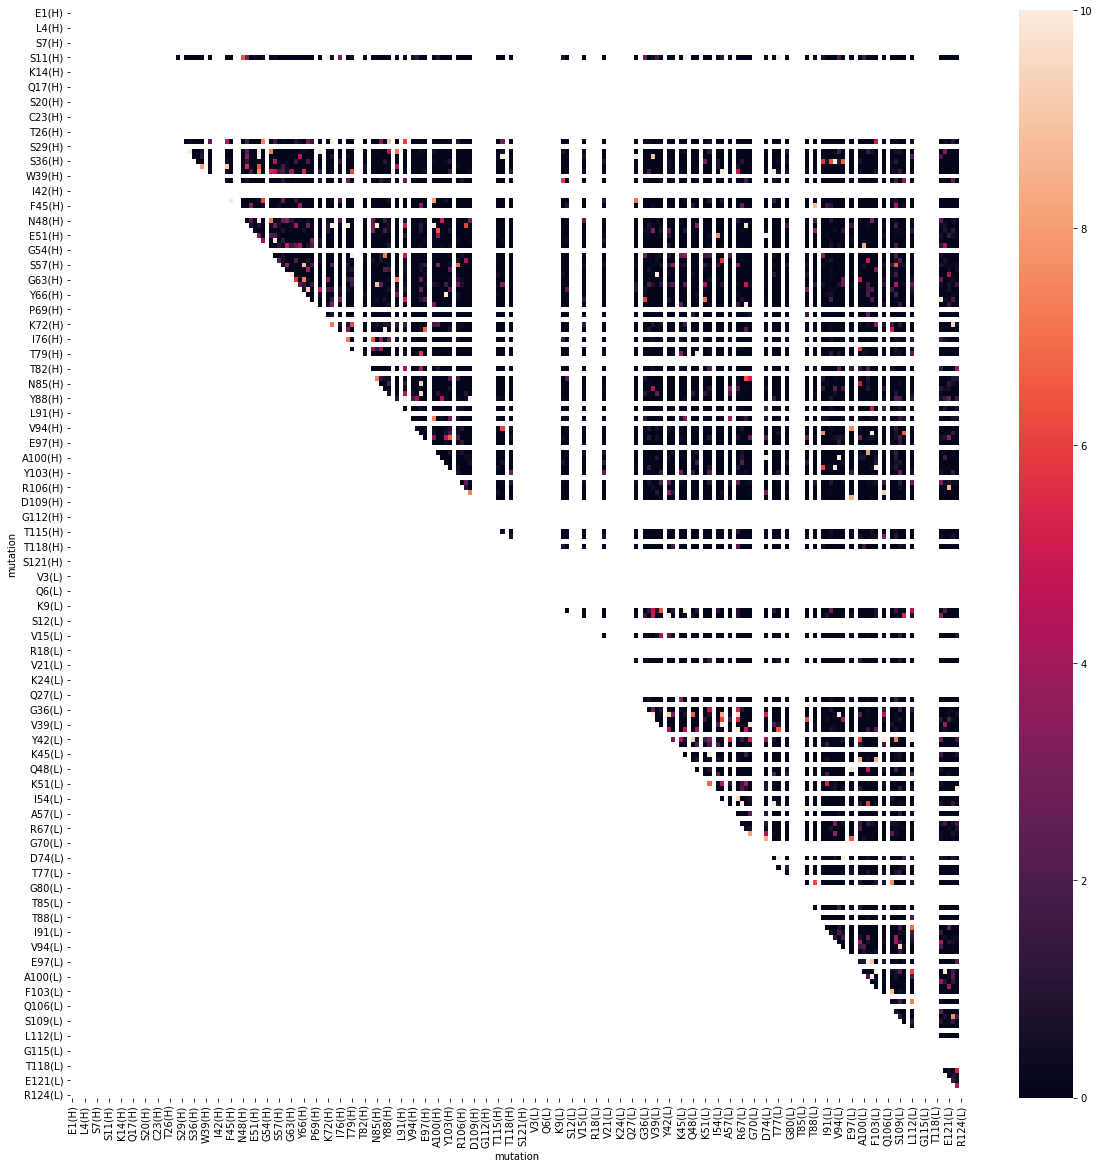

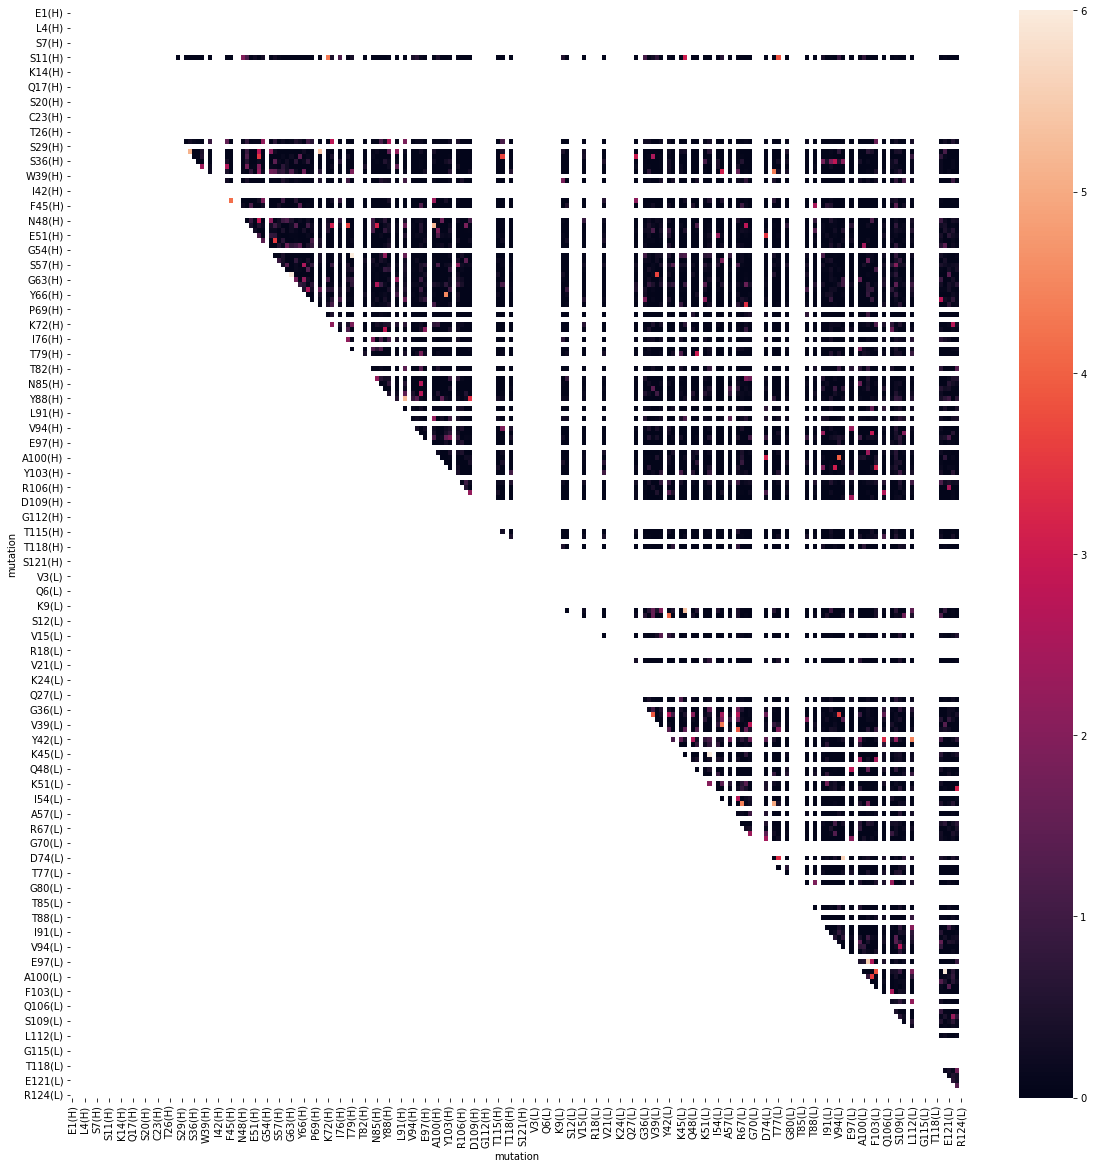

In [430]:
plt.figure(figsize=(20, 20))
sns.heatmap(chi2_df, vmin=0, vmax=10)
plt.show()

plt.figure(figsize=(20, 20))
sns.heatmap(-np.log10(p_value_df), vmin=0, vmax=6)
plt.show()

<AxesSubplot:ylabel='Count'>

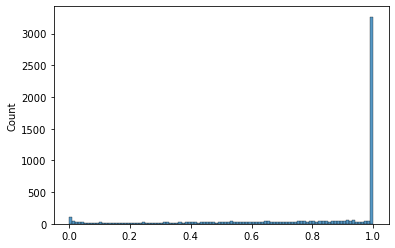

In [432]:
sns.histplot(np.ravel(p_value_df.values), bins=100)